In [1]:
import sys


OUTPUT_TEMPLATE = (
    "Initial T-test p-value: {initial_ttest_p:.3g}\n"
    "Original data normality p-values: {initial_weekday_normality_p:.3g} {initial_weekend_normality_p:.3g}\n"
    "Original data equal-variance p-value: {initial_levene_p:.3g}\n"
    "Transformed data normality p-values: {transformed_weekday_normality_p:.3g} {transformed_weekend_normality_p:.3g}\n"
    "Transformed data equal-variance p-value: {transformed_levene_p:.3g}\n"
    "Weekly data normality p-values: {weekly_weekday_normality_p:.3g} {weekly_weekend_normality_p:.3g}\n"
    "Weekly data equal-variance p-value: {weekly_levene_p:.3g}\n"
    "Weekly T-test p-value: {weekly_ttest_p:.3g}\n"
    "Mann-Whitney U-test p-value: {utest_p:.3g}"
)


def main():
    reddit_counts = sys.argv[1]

    # ...

    print(OUTPUT_TEMPLATE.format(
        initial_ttest_p=0,
        initial_weekday_normality_p=0,
        initial_weekend_normality_p=0,
        initial_levene_p=0,
        transformed_weekday_normality_p=0,
        transformed_weekend_normality_p=0,
        transformed_levene_p=0,
        weekly_weekday_normality_p=0,
        weekly_weekend_normality_p=0,
        weekly_levene_p=0,
        weekly_ttest_p=0,
        utest_p=0,
    ))


if __name__ == '__main__':
    main()


Initial T-test p-value: 0
Original data normality p-values: 0 0
Original data equal-variance p-value: 0
Transformed data normality p-values: 0 0
Transformed data equal-variance p-value: 0
Weekly data normality p-values: 0 0
Weekly data equal-variance p-value: 0
Weekly T-test p-value: 0
Mann-Whitney U-test p-value: 0


In [26]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import date

### cleaning data

In [27]:
# reddit_counts = sys.argv[1]
# counts = pd.read_json(sys.argv[1], lines=True)

reddit_counts = 'reddit-counts.json.gz'
counts = pd.read_json(reddit_counts, lines=True)

display(counts)

,date,subreddit,comment_count
0,2012-02-20,newfoundland,7
1,2015-01-26,Manitoba,1
2,2013-09-07,Yukon,2
3,2014-02-15,saskatchewan,5
4,2014-07-06,canada,1652
...,...,...,...
15465,2012-05-21,Quebec,365
15466,2012-05-21,britishcolumbia,4
15467,2013-09-07,britishcolumbia,5
15468,2011-09-10,Quebec,2


In [28]:
counts = counts[counts['subreddit'] == 'canada'].reset_index(drop=True)
display(counts)
counts.info()

,date,subreddit,comment_count
0,2014-07-06,canada,1652
1,2009-11-08,canada,148
2,2008-05-22,canada,27
3,2009-08-17,canada,252
4,2014-11-28,canada,2685
...,...,...,...
2630,2009-08-07,canada,503
2631,2008-10-17,canada,132
2632,2015-05-24,canada,1737
2633,2012-01-15,canada,1256


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2635 entries, 0 to 2634
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           2635 non-null   datetime64[ns]
 1   subreddit      2635 non-null   object        
 2   comment_count  2635 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 61.9+ KB


In [29]:
# -- https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.year.html
counts['year'] = counts['date'].dt.year
display(counts)
counts.info()

,date,subreddit,comment_count,year
0,2014-07-06,canada,1652,2014
1,2009-11-08,canada,148,2009
2,2008-05-22,canada,27,2008
3,2009-08-17,canada,252,2009
4,2014-11-28,canada,2685,2014
...,...,...,...,...
2630,2009-08-07,canada,503,2009
2631,2008-10-17,canada,132,2008
2632,2015-05-24,canada,1737,2015
2633,2012-01-15,canada,1256,2012


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2635 entries, 0 to 2634
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           2635 non-null   datetime64[ns]
 1   subreddit      2635 non-null   object        
 2   comment_count  2635 non-null   int64         
 3   year           2635 non-null   int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 72.2+ KB


In [30]:
counts = counts[counts['year'].isin([2012, 2013])].reset_index(drop=True)
counts

,date,subreddit,comment_count,year
0,2013-03-14,canada,1657,2013
1,2013-07-08,canada,1369,2013
2,2012-07-04,canada,1343,2012
3,2013-03-11,canada,1619,2013
4,2013-09-11,canada,1909,2013
...,...,...,...,...
726,2013-01-01,canada,2113,2013
727,2013-07-27,canada,1070,2013
728,2012-10-19,canada,1486,2012
729,2012-01-15,canada,1256,2012


In [31]:
# -- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.weekday.html
counts['weekend'] = counts['date'].dt.weekday.isin([5, 6]).astype(bool)
counts

,date,subreddit,comment_count,year,weekend
0,2013-03-14,canada,1657,2013,False
1,2013-07-08,canada,1369,2013,False
2,2012-07-04,canada,1343,2012,False
3,2013-03-11,canada,1619,2013,False
4,2013-09-11,canada,1909,2013,False
...,...,...,...,...,...
726,2013-01-01,canada,2113,2013,False
727,2013-07-27,canada,1070,2013,True
728,2012-10-19,canada,1486,2012,False
729,2012-01-15,canada,1256,2012,True


In [32]:
weekday = counts[counts['weekend'] == False].reset_index(drop=True)
display(weekday)

weekend = counts[counts['weekend'] == True].reset_index(drop=True)
display(weekend)

,date,subreddit,comment_count,year,weekend
0,2013-03-14,canada,1657,2013,False
1,2013-07-08,canada,1369,2013,False
2,2012-07-04,canada,1343,2012,False
3,2013-03-11,canada,1619,2013,False
4,2013-09-11,canada,1909,2013,False
...,...,...,...,...,...
517,2013-04-10,canada,2021,2013,False
518,2013-03-19,canada,1630,2013,False
519,2013-01-01,canada,2113,2013,False
520,2012-10-19,canada,1486,2012,False


,date,subreddit,comment_count,year,weekend
0,2012-02-04,canada,1196,2012,True
1,2012-11-17,canada,1570,2012,True
2,2013-07-14,canada,908,2013,True
3,2013-06-22,canada,984,2013,True
4,2012-07-29,canada,1199,2012,True
...,...,...,...,...,...
204,2012-11-04,canada,1772,2012,True
205,2012-12-09,canada,1350,2012,True
206,2012-12-02,canada,1725,2012,True
207,2013-07-27,canada,1070,2013,True


### visualizing the data

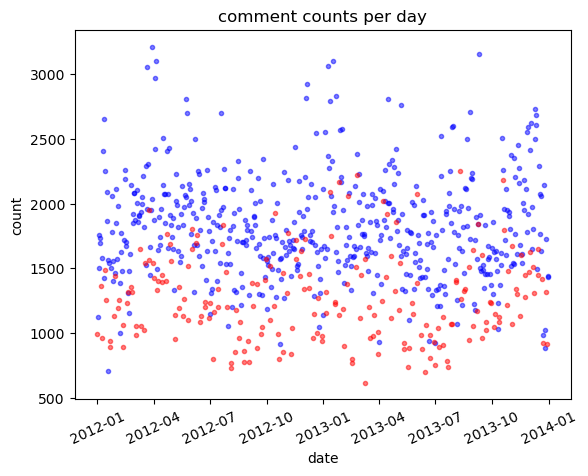

In [33]:
plt.plot(weekday['date'], weekday['comment_count'], 'b.', alpha=0.5)
plt.plot(weekend['date'], weekend['comment_count'], 'r.', alpha=0.5)
plt.xlabel('date')
plt.ylabel('count')
plt.title('comment counts per day')
plt.xticks(rotation=25)
plt.show()

### doing a t-test

In [34]:
wd = weekday['comment_count']
we = weekend['comment_count']

In [35]:
ttest = stats.ttest_ind(wd, we)
print(ttest)

TtestResult(statistic=np.float64(17.70431974179247), pvalue=np.float64(1.3005502847207912e-58), df=np.float64(729.0))


In [36]:
# -- https://ggbaker.ca/data-science/content/inferential.html
# For these samples, we get p < 0.05, so we're going to reject: the distribution seems to not be normal.
# testing for normality
print(stats.normaltest(wd).pvalue)
print(stats.normaltest(we).pvalue)

# Like the normality test: H₀ is that the groups have equal variance. With small p, we reject that assumption.
# testing for equal variance
print(stats.levene(wd, we).pvalue)

1.0091137251707994e-07
0.0015209196859635404
0.04378740989202803


### fix 1: transforming data for better normality/equivariance

In [37]:
# log transforms
log_wd = np.log(wd)
log_we = np.log(we)

# testing for normality
print(stats.normaltest(log_wd).pvalue)
print(stats.normaltest(log_we).pvalue)

# testing for equal variance
print(stats.levene(log_wd, log_we).pvalue)

0.00040159142006827235
0.31493886820667
0.0004190759393372205


In [38]:
# exp transform 
exp_wd = np.exp(wd)
exp_we = np.exp(we)

# testing for normality
print(stats.normaltest(exp_wd).pvalue)
print(stats.normaltest(exp_we).pvalue)

# testing for equal variance
print(stats.levene(exp_wd, exp_we).pvalue)

nan
nan
nan


C:\Users\dayri\miniconda3\envs\cmpt353\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\dayri\miniconda3\envs\cmpt353\lib\site-packages\scipy\stats\_stats_py.py:1054: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
C:\Users\dayri\miniconda3\envs\cmpt353\lib\site-packages\scipy\stats\_morestats.py:3326: RuntimeWarning: invalid value encountered in subtract
  Zij[i] = abs(asarray(samples[i]) - Yci[i])


In [39]:
# sqrt transform
sqrt_wd = np.sqrt(wd)
sqrt_we = np.sqrt(we)

# testing for normality
print(stats.normaltest(sqrt_wd).pvalue)
print(stats.normaltest(sqrt_we).pvalue)

# testing for equal variance
print(stats.levene(sqrt_wd, sqrt_we).pvalue)

0.03687221613365365
0.10760562894666933
0.5560544297516696


In [40]:
# square transform
sqr_wd = wd**2
sqr_we = we**2

# testing for normality
print(stats.normaltest(sqr_wd).pvalue)
print(stats.normaltest(sqr_we).pvalue)

# testing for equal variance
print(stats.levene(sqr_wd, sqr_we).pvalue)

2.7798243005635955e-29
2.991195568683962e-11
7.391434727467261e-08


### fix 2: applying central limit theorem

In [52]:
# -- https://ggbaker.ca/data-science/content/stats-tests.html
# -- https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.isocalendar.html
wdcounts = counts
wdcounts['week'] = wdcounts['date'].dt.isocalendar().week
wdcounts = wdcounts[wdcounts['weekend'] == False].reset_index(drop=True)
# kept getting an issue when aggregating, needed to drop object columns
wdcounts = wdcounts.drop(columns=['subreddit'])
wdcounts

,date,comment_count,year,weekend,week
0,2013-03-14,1657,2013,False,11
1,2013-07-08,1369,2013,False,28
2,2012-07-04,1343,2012,False,27
3,2013-03-11,1619,2013,False,11
4,2013-09-11,1909,2013,False,37
...,...,...,...,...,...
517,2013-04-10,2021,2013,False,15
518,2013-03-19,1630,2013,False,12
519,2013-01-01,2113,2013,False,1
520,2012-10-19,1486,2012,False,42


In [53]:
aggwd = wdcounts.groupby(by=['year', 'week']).mean()
aggwd

date  comment_count  weekend
year week                                            
2012 1    2012-03-04 08:00:00    1491.833333      0.0
     2    2012-01-11 00:00:00    2062.800000      0.0
     3    2012-01-18 00:00:00    1555.000000      0.0
     4    2012-01-25 00:00:00    1662.000000      0.0
     5    2012-02-01 00:00:00    1795.600000      0.0
...                       ...            ...      ...
2013 48   2013-11-27 00:00:00    2190.600000      0.0
     49   2013-12-04 00:00:00    2091.000000      0.0
     50   2013-12-11 00:00:00    2402.400000      0.0
     51   2013-12-18 00:00:00    1964.000000      0.0
     52   2013-12-25 00:00:00    1354.400000      0.0

[104 rows x 3 columns]

In [54]:
wecounts = counts
wecounts['week'] = wecounts['date'].dt.isocalendar().week
wecounts = wecounts[wecounts['weekend'] == True].reset_index(drop=True)
# kept getting an issue when aggregating, needed to drop object columns
wecounts = wecounts.drop(columns=['subreddit'])
wecounts

,date,comment_count,year,weekend,week
0,2012-02-04,1196,2012,True,5
1,2012-11-17,1570,2012,True,46
2,2013-07-14,908,2013,True,28
3,2013-06-22,984,2013,True,25
4,2012-07-29,1199,2012,True,30
...,...,...,...,...,...
204,2012-11-04,1772,2012,True,44
205,2012-12-09,1350,2012,True,49
206,2012-12-02,1725,2012,True,48
207,2013-07-27,1070,2013,True,30


In [55]:
aggwe = wecounts.groupby(by=['year', 'week']).mean()
aggwe

date  comment_count  weekend
year week                                            
2012 1    2012-01-07 12:00:00         1163.0      1.0
     2    2012-01-14 12:00:00         1372.0      1.0
     3    2012-01-21 12:00:00          915.5      1.0
     4    2012-01-28 12:00:00         1285.0      1.0
     5    2012-02-04 12:00:00         1228.0      1.0
...                       ...            ...      ...
2013 48   2013-11-30 12:00:00         1553.0      1.0
     49   2013-12-07 12:00:00         1412.5      1.0
     50   2013-12-14 12:00:00         1547.0      1.0
     51   2013-12-21 12:00:00         1173.5      1.0
     52   2013-12-28 12:00:00         1117.5      1.0

[104 rows x 3 columns]

In [56]:
# testing for normality
print(stats.normaltest(aggwd['comment_count']).pvalue)
print(stats.normaltest(aggwe['comment_count']).pvalue)

# testing for equal variance
print(stats.levene(aggwd['comment_count'], aggwe['comment_count']).pvalue)

0.32799684545078256
0.1728097556434448
0.2011089518733347


In [59]:
aggttest = stats.ttest_ind(aggwd['comment_count'], aggwe['comment_count'])
print(aggttest)
# reject null since p < 0.05
print(aggttest.pvalue)

TtestResult(statistic=np.float64(14.841048220894072), pvalue=np.float64(2.2808975965687838e-34), df=np.float64(206.0))
2.2808975965687838e-34


### fix 3: try a non-parametric test